In [139]:
import json
import os
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms as T
from PIL import Image
import xml.etree.ElementTree as ET

In [140]:
main_dir = '/zhome/97/a/203937/02516_poster_3/'
img_dir = main_dir + 'Potholes/annotated-images/'
proposal_file_path = main_dir + 'labeled_proposals_edge_boxes.json'

# Make sure the above paths are correct
assert os.path.exists(main_dir), f"Main directory does not exist: {main_dir}"
assert os.path.exists(img_dir), f"Image directory does not exist: {img_dir}"
assert os.path.exists(proposal_file_path), f"Proposal file does not exist: {proposal_file_path}"
print("All paths are verified and exist.")

All paths are verified and exist.


In [141]:
with open(proposal_file_path, 'r') as f:
    proposals = json.load(f)

In [142]:
class PotholeDatasetFromProposals(Dataset):
    def __init__(self, image_file_list, img_dir, proposals, transform=None):
        """
        Initialize the Pothole dataset using only the proposals JSON.
        
        Args:
            image_file_list (list): List of image filenames.
            img_dir (str): Directory where images are stored.
            proposals (dict): Proposed bounding boxes and labels for each image.
            transform (callable, optional): Optional transform to be applied on an image.
        """
        self.image_file_list = image_file_list
        self.img_dir = img_dir
        self.proposals = proposals
        self.transform = transform

        # Determine the target size if a Resize transform is provided
        new_size = None
        if transform is not None:
            for t in transform.transforms:
                if isinstance(t, T.Resize):
                    new_size = t.size  # Target size for resizing (height, width)

        self.new_size = new_size

    def __len__(self):
        return len(self.image_file_list)

    def __getitem__(self, idx):
        # Get image filename
        img_name = self.image_file_list[idx]
        image_path = os.path.join(self.img_dir, img_name)
        
        # Load the image
        image = Image.open(image_path).convert("RGB")

        # Original size of the image
        original_size = image.size

        new_size = self.new_size
        # Scaling factors if Resize transform is applied
        if new_size:
            scale_x = new_size[0] / original_size[0]
            scale_y = new_size[1] / original_size[1]
        else:
            scale_x = scale_y = 1.0  # No resizing, so scaling factors are 1

        # Retrieve proposals for this image
        boxes = []
        labels = []
        at_least_one_pothole = False
        for proposal in self.proposals.get(img_name, []):
            # Original bounding box coordinates
            x, y, width, height = (
                proposal["x"],
                proposal["y"],
                proposal["width"],
                proposal["height"],
            )

            # Scale bounding box coordinates
            x_resized = x * scale_x
            y_resized = y * scale_y
            width_resized = width * scale_x 
            height_resized = height * scale_y
            
            boxes.append([x_resized, y_resized, width_resized, height_resized])
            if proposal['label'] == "pothole":
                at_least_one_pothole = True
                label = 1
            else:
                label = 0
            labels.append(label)

        # If no potholes are found, add from the label from xml file
        if not at_least_one_pothole:
            print(f"No potholes found in proposals for {img_name}. Adding from XML file.")
            xml_file = img_name.replace('.jpg', '.xml')
            xml_path = os.path.join(self.img_dir, xml_file)
            tree = ET.parse(xml_path)
            root = tree.getroot()
            for obj in root.findall("object"):
                if obj.find("name").text == "pothole":
                    bbox = obj.find("bndbox")
                    xmin = int(bbox.find("xmin").text)
                    ymin = int(bbox.find("ymin").text)
                    xmax = int(bbox.find("xmax").text)
                    ymax = int(bbox.find("ymax").text)
                    width = xmax - xmin
                    height = ymax - ymin

                    # Scale bounding box coordinates
                    x_resized = xmin * scale_x
                    y_resized = ymin * scale_y
                    width_resized = width * scale_x
                    height_resized = height * scale_y

                    boxes.append([x_resized, y_resized, width_resized, height_resized])
                    labels.append(1)

        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        labels = torch.as_tensor(labels, dtype=torch.int8)
        
        # Apply transformation to the image if specified
        if self.transform:
            image = self.transform(image)
        
        # Prepare target dictionary
        target = {}
        target['boxes'] = boxes
        target['labels'] = labels
        
        return image, target


In [143]:
image_file_list = list(proposals.keys())  # Image files in the proposals

# Define transformations
transform = T.Compose([
    T.Resize((720, 720)), # FOR NOW ALIGN WITH THE PROPOSALS, CHANGE DATALOADERS TO ALIGN WITH THE TRANSFORM
    T.ToTensor()
])

# Initialize dataset with only proposals
dataset = PotholeDatasetFromProposals(
    image_file_list=image_file_list,
    img_dir=img_dir,
    proposals=proposals,
    transform=transform
)

# Define DataLoader
dataloader = DataLoader(dataset, batch_size=4, shuffle=True, num_workers=4, collate_fn=lambda x: tuple(zip(*x)))

# # Example loop to access batched data
# for images, targets in dataloader:
#     print("Batch of images:", images)
#     print("Batch of targets:", targets)
#     break  # Display only the first batch


No potholes found in proposals for img-177.jpg. Adding from XML file.
No potholes found in proposals for img-42.jpg. Adding from XML file.
No potholes found in proposals for img-239.jpg. Adding from XML file.
No potholes found in proposals for img-12.jpg. Adding from XML file.
No potholes found in proposals for img-280.jpg. Adding from XML file.
No potholes found in proposals for img-284.jpg. Adding from XML file.
No potholes found in proposals for img-167.jpg. Adding from XML file.
No potholes found in proposals for img-294.jpg. Adding from XML file.


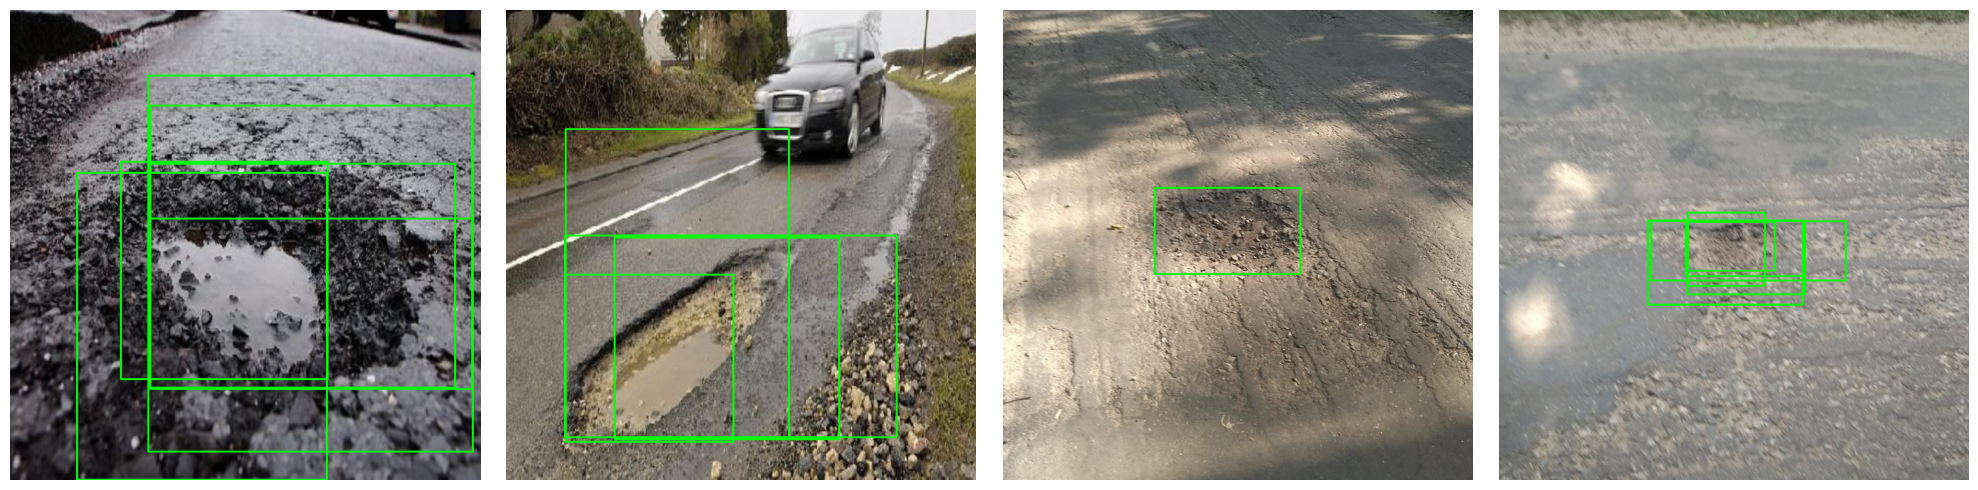

In [144]:
import matplotlib.pyplot as plt
import numpy as np
import cv2

def plot_images(images, targets, denormalize=False):
    fig, axes = plt.subplots(1, len(images), figsize=(20, 5))
    
    for i, (image, target) in enumerate(zip(images, targets)):
        #if image has any boxes that are not background
        # if any([label != 0 for label in target['labels']]):
        #     continue
        
        # Convert image to numpy and denormalize
        image = image.permute(1, 2, 0).cpu().numpy()  # Convert to (H, W, C) and move to CPU if necessary
        if denormalize:
            mean = np.array([0.485, 0.456, 0.406])
            std = np.array([0.229, 0.224, 0.225])
            image = std * image + mean  # Denormalize
            image = np.clip(image, 0, 1)  # Clip to [0, 1] range for display
        
        # Convert image to uint8 for OpenCV and plotting
        image = (image * 255).astype(np.uint8)
        
        # Convert RGB to BGR for OpenCV compatibility
        image_bgr = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)

        # Draw bounding boxes on the BGR image
        for box, label in zip(target['boxes'], target['labels']):
            # Convert box coordinates to numpy integers
            x, y, w, h = box.numpy().astype(int)
            
            # Define color: red for background, green for pothole
            color = (0, 0, 255) if label == 0 else (0, 255, 0)
            
            # Draw the rectangle on the image
            if label == 1:
                image_bgr = cv2.rectangle(image_bgr, (x, y), (x + w, y + h), color, 2)
        
        # Convert BGR image back to RGB for display in matplotlib
        image_rgb = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2RGB)
        
        # Display the image
        axes[i].imshow(image_rgb)
        axes[i].axis('off')
    
    plt.tight_layout()
    plt.show()

# Display the first batch of images
images, targets = next(iter(dataloader))
plot_images(images, targets)


In [145]:
from sklearn.model_selection import train_test_split

# Define the split ratios
train_ratio = 0.7  # 70% of the data for training
val_ratio = 0.15   # 15% for validation
test_ratio = 0.15  # 15% for testing

# Create indices for the dataset
dataset_size = len(dataset)
indices = list(range(dataset_size))

# First split: training set and remaining set
train_indices, temp_indices = train_test_split(indices, test_size=(1 - train_ratio), random_state=42)

# Second split: validation and test set from the remaining set
val_size = int(len(temp_indices) * (val_ratio / (val_ratio + test_ratio)))  # Adjust for remaining size
val_indices, test_indices = temp_indices[:val_size], temp_indices[val_size:]


In [146]:
from torch.utils.data import Subset

# Create subsets for train, validation, and test sets
train_dataset = Subset(dataset, train_indices)
val_dataset = Subset(dataset, val_indices)
test_dataset = Subset(dataset, test_indices)


In [147]:
from torch.utils.data import DataLoader

# Define batch size
batch_size = 8

# Create DataLoaders for each subset
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4, collate_fn=lambda x: tuple(zip(*x)))
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=4, collate_fn=lambda x: tuple(zip(*x)))
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=4, collate_fn=lambda x: tuple(zip(*x)))
